In [1]:
# try random policy on the kitty
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import sys
from collections import defaultdict

import random
from datetime import datetime

# number of episodes 
n_epi = 200
alpha = 0.5
epsilon = 0.01

act_dict = {
    "LEFT": 0,
    "DOWN": 1,
    "RIGHT": 2,
    "UP": 3,
    "PAUSE": 4,
}

In [2]:
desc_file = open("map_14_14_v1.txt", "r") 
  
desc_content = desc_file.read() 

# for the env that elf is the main agent
desc = desc_content.split("\n") 
# for the env that kitty is the main agent
desc_k = desc_content.split("\n") 
desc = [d for d in desc if d!='']
desc_k = [d for d in desc_k if d!='']

desc_file.close() 
n_dim = len(desc[0])

# location of kitty, cat food, pet home, elf, starting point, goal point
K_loc, C_loc, P_loc, E_loc, S_loc, G_loc = list(), list(), list(), list(), list(), list()

for i in range(len(desc)):
    if 'K' in desc[i]:
        
        K_loc.extend([i, desc[i].index('K')])
    if 'C' in desc[i]:
        C_loc.extend([i, desc[i].index('C')])
    if 'S' in desc[i]:
        S_loc.extend([i, desc[i].index('S')])
    if 'G' in desc[i]:
        G_loc.extend([i, desc[i].index('G')])

# kitty location is the same as pet home location initially
P_loc.extend([K_loc[0], K_loc[1]])
# elf location is the same as starting point location initially
E_loc.extend([S_loc[0], S_loc[1]])

# locate holes 
H_loc_list = list()
for i in range(len(desc)):
    for d in range(len(desc[i])):
        if desc[i][d] == 'H':
            H_loc_list.append([i, d])
            
# Update desc_k for the env where kitty is the main agent
# use P and C as starting point and goal to train kitty's Q-table
# S and G are replaced by K and C
desc_k[S_loc[0]] = desc_k[S_loc[0]][:S_loc[1]]+'K'+desc_k[S_loc[0]][S_loc[1]+1:]
desc_k[G_loc[0]] = desc_k[G_loc[0]][:G_loc[1]]+'C'+desc_k[G_loc[0]][G_loc[1]+1:]
desc_k[P_loc[0]] = desc_k[P_loc[0]][:P_loc[1]]+'S'+desc_k[P_loc[0]][P_loc[1]+1:]
desc_k[C_loc[0]] = desc_k[C_loc[0]][:C_loc[1]]+'G'+desc_k[C_loc[0]][C_loc[1]+1:]



In [3]:
def epsilon_greedy(env, epsilon, num_act, Q):
    """
    return a function to compute probability of choosing each action on the given state
    """
    def policy_s(state):
        action_probs = np.full(num_act,epsilon/num_act)
        a = np.argmax(Q[state])
        action_probs[a] += (1-epsilon)
        
        return action_probs
    return policy_s


In [4]:
elf_info = {
    'agent': E_loc, # current location of elf
    'from': S_loc, 
    # if elf is seeking starting point or goal. True for goal
    'if_to' : True,
    'to' : G_loc,
    'holes' : H_loc_list,
    'current_from' : P_loc, # current agent getting trained is kitty and comes from P
    'current_to' : C_loc,
    }

kitty_info = {
    'agent': K_loc, # current location of kitty
    'from': P_loc, 
    # if kitty is seeking food or home. True for food
    'if_to' : True,
    'to' : C_loc,
    'holes' : H_loc_list,
    'current_from' : S_loc, # # current agent getting trained is elf and comes from starting point
    'current_to' : G_loc,
    }


state_dict = {
    "current_from": 'S',
    "current_to": 'G',
    "other_from": 'P',
    "other_to": 'C',
    "other_agent": 'K',
}

In [5]:
def to_original_component(env, other_agent, state_dict = state_dict):
    # in k_env_f: change the grid of elf_info['agent'] to its original value in the map
    # in e_env_g: change the grid of kitty_info['agent'] to its original value in the map
    
    if other_agent['agent'] in other_agent['holes']:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'H'
        
    # if the other agent is locating on current agent's from
    elif other_agent['agent'] == other_agent['current_from']:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['current_from'].encode('UTF-8')
        
    # if the other agent is locating on current agent's to
    elif other_agent['agent'] == other_agent['current_to']:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['current_to'].encode('UTF-8')
        
    elif other_agent['agent'] == other_agent['from']:    
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['other_from'].encode('UTF-8')
        
    elif other_agent['agent'] == other_agent['to']: 
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = state_dict['other_to'].encode('UTF-8')
        
    else:
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'F'
        
    return env, other_agent

In [6]:
def other_agent_move(env, other_agent, num_dim, Q_other_agent):
    
    # if the other agent already arrives at its destination, no need to move the other agent
    if other_agent['agent'] != other_agent['to']:
        env, other_agent = to_original_component(env, other_agent)
        # compute other agent's state
        other_agent_state = other_agent['agent'][0] * num_dim + other_agent['agent'][1] 
        
        # get other agent's action
        other_agent_act = np.argmax(Q_other_agent[other_agent_state])
        
        if other_agent_act == 0: # LEFT
            other_agent['agent'][1] = max(other_agent['agent'][1]-1, 0)
        elif other_agent_act ==1: # DOWN
            other_agent['agent'][0] = min(other_agent['agent'][0]+1, num_dim -1)
        elif other_agent_act == 2: # RIGHT
            other_agent['agent'][1] = min(other_agent['agent'][1]+1, num_dim -1)
        elif other_agent_act ==3: # UP
            other_agent['agent'][0] = max(other_agent['agent'][0]-1, 0)
        
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'K'
    
    return env, other_agent

In [7]:
def other_agent_move_train(env, other_agent, num_dim, Q_other_agent, epsilon = epsilon):
    
    # if the other agent already arrives at its destination, no need to move the other agent
    if other_agent['agent'] != other_agent['to']:
        env, other_agent = to_original_component(env, other_agent)
        
        # compute other agent's state
        other_agent_state = other_agent['agent'][0] * num_dim + other_agent['agent'][1] 
        
        # get other agent's policy
        other_act_policy = epsilon_greedy(env, epsilon, env.action_space.n, Q_other_agent)
        other_act_probs = other_act_policy(other_agent_state)
        
        # get other agent's action
        other_agent_act = np.random.choice(len(other_act_probs), p = other_act_probs)
                
        if other_agent_act == 0: # LEFT
            other_agent['agent'][1] = max(other_agent['agent'][1]-1, 0)
        elif other_agent_act ==1: # DOWN
            other_agent['agent'][0] = min(other_agent['agent'][0]+1, num_dim -1)
        elif other_agent_act == 2: # RIGHT
            other_agent['agent'][1] = min(other_agent['agent'][1]+1, num_dim -1)
        elif other_agent_act ==3: # UP
            other_agent['agent'][0] = max(other_agent['agent'][0]-1, 0)
        
        env.desc[other_agent['agent'][0], other_agent['agent'][1]] = b'K'
    
    return env, other_agent

In [8]:
def Q_learning(kitty, elf, desc = desc, desc_k = desc_k, num_episodes = n_epi, \
               num_dim= n_dim, discount_factor = 1.0, alpha = alpha, epsilon = epsilon):
    
    # env that the kitty heading for food
    k_env_f = gym.make('FrozenLake-v1', desc=desc_k, is_slippery=False, render_mode = 'rgb_array')
    # env that elf heading for goal
    e_env_g = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')
    # get num of actions
    nA = e_env_g.action_space.n
    
    Q_kitty = defaultdict(lambda: np.zeros(nA)) # initialize Q-value for kitty
    Q_elf = defaultdict(lambda: np.zeros(nA)) # initialize Q-value for elf

    # initialize policy for kitty and elf
    policy_kitty = epsilon_greedy(k_env_f, epsilon, nA, Q_kitty)
    policy_elf = epsilon_greedy(e_env_g, epsilon, nA, Q_elf)
    
    # to record for each record, how many iterations it takes to reach termination
    episode_iterations = np.zeros(num_episodes)
    # to record for each record, how much reward it got eventually
    episode_reward = np.zeros(num_episodes)
    
    for i_epi in range(num_episodes):
        
        print("\rEpisode: {}".format(i_epi+1), flush = True, end="")
        """
        if (i_epi+1) %100 == 0:
            print("\rEpisode: {}".format(i_epi+1), flush = True, end="")
        """
        
        # env that the kitty heading for food
        k_env_f = gym.make('FrozenLake-v1', desc=desc_k, is_slippery=False, render_mode = 'rgb_array')
        # env that elf heading for goal
        e_env_g = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')
        # initialize kitty's state    
        k_state = k_env_f.reset()[0]
        # initialize kitty's state    
        e_state = e_env_g.reset()[0]
               
        num_iter = 1
        num_k_terminate,  num_e_terminate= 0, 0 
       
        while num_k_terminate == 0 or num_e_terminate == 0:
            # print(num_iter, 'iterations')
            if num_k_terminate == 0:
                ######################
                ## Train kitty first##
                ######################
                k_act_probs = policy_kitty(k_state)

                 # randomly choose an action following probability in k_act_probs
                k_action = np.random.choice(len(k_act_probs), p = k_act_probs)
                k_next_state, k_reward, k_terminated, k_truncated, k_info = k_env_f.step(k_action)

                k_max_next_Q = max(Q_kitty[k_next_state])
                Q_kitty[k_state][k_action] += alpha *(k_reward + discount_factor * k_max_next_Q - \
                                                      Q_kitty[k_state][k_action])

                episode_iterations[i_epi] = num_iter+1
                episode_reward[i_epi] += k_reward

                # update elf's location in kitty's env
                k_env_f, elf = other_agent_move_train(k_env_f, elf, num_dim, Q_elf)
                
                k_state = k_next_state
                
                if k_terminated:
                    num_k_terminate += 1
            
            if num_e_terminate == 0:
                ##################
                ## Train elf now##
                ##################

                # update kitty's location in elf's env
                e_env_g, kitty = other_agent_move_train(e_env_g, kitty, num_dim, Q_kitty)

                e_act_probs = policy_elf(e_state)

                # randomly choose an action following probability in e_act_probs
                e_action = np.random.choice(len(e_act_probs), p = e_act_probs)
                e_next_state, e_reward, e_terminated, e_truncated, e_info = e_env_g.step(e_action)

                e_max_next_Q = max(Q_elf[e_next_state])
                Q_elf[e_state][e_action] += alpha *(e_reward + discount_factor * e_max_next_Q - \
                                                      Q_elf[e_state][e_action])

                episode_iterations[i_epi] = num_iter+1
                episode_reward[i_epi] += e_reward
                
                e_state = e_next_state

                if e_terminated:
                    num_e_terminate += 1
            
            
            
            num_iter +=1
            
        
    return Q_kitty, Q_elf, episode_iterations, episode_reward



Q_kitty, Q_elf, episode_iterations, episode_reward = Q_learning(kitty = kitty_info, elf = elf_info)

Episode: 200

In [9]:

def train_plot(epi_iter, epi_reward, n_epi = n_epi, run_type = "once"):
    fig, axs = plt.subplots(2)
    axs[0].set_title(f'{n_epi} Episodes and iterations, alpha = {alpha}, epsilon = {epsilon}')
    axs[0].set_xlabel('Number of episodes')
    axs[0].set_ylabel('Number of iterations')
    axs[1].set_title(f'{n_epi} Episodes and reward')
    axs[1].set_xlabel('Number of episodes')
    axs[1].set_ylabel('Reward')
    axs[0].plot(epi_iter)
    axs[1].plot(epi_reward)
    fig.tight_layout()

    plt.savefig(f'Plot/{n_dim}x{n_dim}_{n_epi} Episodes and iterations _{run_type}_method_2.png',\
                bbox_inches='tight')

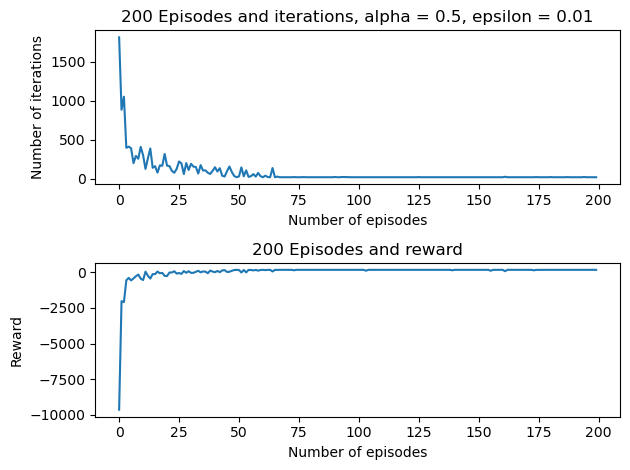

In [10]:
train_plot(episode_iterations, episode_reward)


In [11]:

env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')

# calculate state of S and G
S_state = S_loc[0] * n_dim + S_loc[1]
G_state = G_loc[0] * n_dim + G_loc[1]


# datetime object containing current date and time
now = datetime.now().strftime("%d-%m-%Y %H_%M_%S")
file_name = f"Demo/epi_{n_epi}/kitty_qlearning-{n_dim}x{n_dim}map_once_{n_epi}_episodes_{now}.gif"


def Demo_GIF(kitty, desc = desc, Q_kitty = Q_kitty, \
                     Q_elf = Q_elf, num_dim = n_dim, address = file_name, \
                     S_state = S_state, G_state = G_state):
    
    pics = []
    
    env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')
    
    kitty['agent'][0], kitty['agent'][1] = kitty['from'][0], kitty['from'][1]  
    
    state = env.reset()[0]
    
    num_collision = 0
    
    while True:
        pics.append(env.render())
        
        # choose kitty's action based on kitty's Q table first
        env, kitty = other_agent_move(env, kitty, num_dim, Q_kitty) 
        
        # choose elf's action based on Q-table when heading to goal
        action = np.argmax(Q_elf[state]) 

        next_state, reward, terminated, truncated, info = env.step(action)

        if terminated:
            break
    
        state = next_state
        k_state = kitty['agent'][0] * num_dim + kitty['agent'][1]
        if k_state == state:
            num_collision += 1
    
    print(f'Number of collisions when episode number is {n_epi}:', num_collision)
    print(f'Demo GIF is: {file_name}')

    pics.append(env.render())
    env.close()

    imageio.mimsave(address, pics)
    

In [12]:
Demo_GIF(kitty_info)

Number of collisions when episode number is 200: 0
Demo GIF is: Demo/epi_200/kitty_qlearning-14x14map_once_200_episodes_26-05-2024 18_04_24.gif
